# ID: 6031040921
## Name: Phatcharapon Jumruspun

# HW 3 - Neural POS Tagger

In this exercise, you are going to build a set of deep learning models on part-of-speech (POS) tagging using Tensorflow 2. Tensorflow is a deep learning framwork developed by Google to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for POS tagging in Thai using NECTEC's ORCHID corpus. You will build one model for each of the following type:

- Neural POS Tagging with Word Embedding using Fixed / non-Fixed Pretrained weights
- Neural POS Tagging with Viterbi / Marginal CRF

Pretrained word embeddding are already given for you to use (albeit, a very bad one).

We also provide the code for data cleaning, preprocessing and some starter code for tensorflow 2 in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

### Don't forget to change hardware accelrator to GPU in runtime on Google Colab ###

## 1. Setup and Preprocessing

We use POS data from [ORCHID corpus](https://www.nectec.or.th/corpus/index.php?league=pm), which is a POS corpus for Thai language.
A method used to read the corpus into a list of sentences with (word, POS) pairs have been implemented already. The example usage has shown below.
We also create a word vector for unknown word by random.

In [ ]:
%tensorflow_version 2.x

In [ ]:
!gdown --id 1tsfqDG8-HL4nkq0pq0HGifND_qDSHq-f
!unzip resources.zip

Downloading...
From: https://drive.google.com/uc?id=1tsfqDG8-HL4nkq0pq0HGifND_qDSHq-f
To: /content/resources.zip
153MB [00:02, 59.4MB/s]
Archive:  resources.zip
   creating: resources/
   creating: resources/embeddings/
  inflating: resources/embeddings/emb_reader.py  
   creating: __MACOSX/
   creating: __MACOSX/resources/
   creating: __MACOSX/resources/embeddings/
  inflating: __MACOSX/resources/embeddings/._emb_reader.py  
 extracting: resources/embeddings/__init__.py  
  inflating: __MACOSX/resources/embeddings/.___init__.py  
   creating: resources/embeddings/__pycache__/
  inflating: resources/embeddings/__pycache__/__init__.cpython-36.pyc  
   creating: __MACOSX/resources/embeddings/__pycache__/
  inflating: __MACOSX/resources/embeddings/__pycache__/.___init__.cpython-36.pyc  
  inflating: resources/embeddings/__pycache__/emb_reader.cpython-36.pyc  
  inflating: __MACOSX/resources/embeddings/__pycache__/._emb_reader.cpython-36.pyc  
  inflating: __MACOSX/resources/embeddings/._

In [ ]:
!pip install python-crfsuite
!pip install tensorflow-addons
!pip install tf2crf

     |████████████████████████████████| 747kB 4.2MB/s 


In [ ]:
%tensorflow_version 2.x

In [ ]:
from data.orchid_corpus import get_sentences
import numpy as np
import numpy.random
import tensorflow as tf
np.random.seed(42)

In [ ]:
yunk_emb =np.random.randn(32)
train_data = get_sentences('train')
test_data = get_sentences('test')
print(train_data[0])

[('การ', 'FIXN'), ('ประชุม', 'VACT'), ('ทาง', 'NCMN'), ('วิชาการ', 'NCMN'), ('<space>', 'PUNC'), ('ครั้ง', 'CFQC'), ('ที่ 1', 'DONM')]


Next, we load pretrained weight embedding using pickle. The pretrained weight is a dictionary which map a word to its embedding.

In [ ]:
import pickle
fp = open('basic_ff_embedding.pt', 'rb')
embeddings = pickle.load(fp)
fp.close()

The given code below generates an indexed dataset(each word is represented by a number) for training and testing data. The index 0 is reserved for padding to help with variable length sequence. (Additionally, You can read more about padding here [https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/])

## 2. Prepare Data

In [ ]:
word_to_idx ={}
idx_to_word ={}
label_to_idx = {}
for sentence in train_data:
    for word,pos in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)+1
            idx_to_word[word_to_idx[word]] = word
        if pos not in label_to_idx:
            label_to_idx[pos] = len(label_to_idx)+1
word_to_idx['UNK'] = len(word_to_idx)

n_classes = len(label_to_idx.keys())+1

This section is tweaked a little from the demo, word2features will return word index instead of features, and sent2labels will return a sequence of word indices in the sentence.

In [ ]:
def word2features(sent, i, emb):
    word = sent[i][0]
    if word in word_to_idx :
        return word_to_idx[word]
    else :
        return word_to_idx['UNK']

def sent2features(sent, emb_dict):
    return np.asarray([word2features(sent, i, emb_dict) for i in range(len(sent))])

def sent2labels(sent):
    return numpy.asarray([label_to_idx[label] for (word, label) in sent],dtype='int32')

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [ ]:
train_data[100]

[('รัฐมนตรีว่าการ', 'NCMN'),
 ('กระทรวงวิทยาศาสตร์เทคโนโลยีและการพลังงาน', 'NPRP'),
 ('<space>', 'PUNC'),
 ('ประธานกรรมการ', 'NCMN')]

In [ ]:
sent2features(train_data[100], embeddings)

array([ 29, 327,   5, 328])

In [ ]:
sent2labels(train_data[100])

array([ 3, 10,  4,  3], dtype=int32)

In [ ]:
sent2tokens(train_data[100])

['รัฐมนตรีว่าการ',
 'กระทรวงวิทยาศาสตร์เทคโนโลยีและการพลังงาน',
 '<space>',
 'ประธานกรรมการ']

Next we create train and test dataset, then we use tensorflow 2 to post-pad the sequence to max sequence with 0. Our labels are changed to a one-hot vector.

In [ ]:
%%time
x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
y_train = [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]

CPU times: user 353 ms, sys: 0 ns, total: 353 ms
Wall time: 360 ms


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_temp =[]
for i in range(len(y_train)):
    y_temp.append(np.eye(n_classes)[y_train[i]][np.newaxis,:])
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
del(y_temp)

In [ ]:
print(x_train[100],x_train.shape)
print(y_train[100][3],y_train.shape)

[ 29 327   5 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] (18500, 102)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (18500, 102, 48)


## 3. Evaluate

Our output from tf keras is a distribution of problabilities on all possible label. outputToLabel will return an indices of maximum problability from output sequence.

evaluation_report is the same as in the demo

In [ ]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [ ]:
import pandas as pd
from IPython.display import display

def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set))
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)
    return df

## 4. Train a model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from tensorflow.keras.optimizers import Adam

The model is this section is separated to two groups

- Neural POS Tagger (4.1)
- Neural CRF POS Tagger (4.2)

## 4.1.1 Neural POS Tagger  (Example)

We create a simple Neural POS Tagger as an example for you. This model dosen't use any pretrained word embbeding so it need to use Embedding layer to train the word embedding from scratch.

Instead of using tensorflow.keras.models.Sequential, we use tensorflow.keras.models.Model. The latter is better as it can have multiple input/output, of which Sequential model could not. Due to this reason, the Model class is widely used for building a complex deep learning model.

In [ ]:
# constant words in each input = 102
# that means we accept 102 words maximum for each sentence
inputs = Input(shape=(102,), dtype='int32') 

# mask_zero will mask padded values, for model to ignore
# We need to insert pretrain weight into Embedding here in TODO#2
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)

# True: return all words along
# False: only return the last one
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation='softmax'))(output)
model = Model(inputs, output)
model.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 102, 32)           480608    
_________________________________________________________________
bidirectional (Bidirectional (None, 102, 64)           12672     
_________________________________________________________________
dropout (Dropout)            (None, 102, 64)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 102, 48)           3120      
Total params: 496,400
Trainable params: 496,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model.fit(x_train,y_train,batch_size=64,epochs=10,verbose=1)

Epoch 1/10
290/290 [==============================] - 42s 121ms/step - loss: 0.3901 - categorical_accuracy: 0.4110
Epoch 2/10
290/290 [==============================] - 35s 121ms/step - loss: 0.0685 - categorical_accuracy: 0.8911
Epoch 3/10
290/290 [==============================] - 35s 121ms/step - loss: 0.0377 - categorical_accuracy: 0.9318
Epoch 4/10
290/290 [==============================] - 38s 130ms/step - loss: 0.0294 - categorical_accuracy: 0.9451
Epoch 5/10
290/290 [==============================] - 41s 141ms/step - loss: 0.0251 - categorical_accuracy: 0.9510
Epoch 6/10
290/290 [==============================] - 36s 123ms/step - loss: 0.0225 - categorical_accuracy: 0.9547
Epoch 7/10
290/290 [==============================] - 35s 122ms/step - loss: 0.0215 - categorical_accuracy: 0.9565
Epoch 8/10
290/290 [==============================] - 35s 122ms/step - loss: 0.0195 - categorical_accuracy: 0.9600
Epoch 9/10
290/290 [==============================] - 35s 122ms/step - loss: 0.0

In [ ]:
model.save_weights('./data/model_no_crf.h5')
# model.load_weights('model.h5')

In [ ]:
%%time
y_pred=model.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]

CPU times: user 6.86 s, sys: 306 ms, total: 7.16 s
Wall time: 4.97 s


In [ ]:
df_no_crf = evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8639,99.5929,99.7283,3670
1,2,94.1458,95.3443,94.7413,7864
2,3,91.0252,96.625,93.7416,16319
3,4,99.9456,99.5357,99.7402,12862
4,5,100,98.5075,99.2481,66
5,6,99.7821,87.7395,93.3741,458
6,7,98.2893,96.7292,97.503,2011
7,8,64.8148,50.6024,56.8336,210
8,9,70.3822,60.0543,64.8094,221
9,10,63.7993,42.4315,50.9664,356


## 4.2 CRF Viterbi

Your next task is to incorporate Conditional random fields (CRF) to your model.

To use the CRF layer, you need to use an extension repository for tensorflow library, call tf2crf. If you want to see the detailed implementation, you should read the official tensorflow extention of CRF (https://www.tensorflow.org/addons/api_docs/python/tfa/text).

tf2crf link :  https://github.com/xuxingya/tf2crf

For inference, you should look at crf.py at the method call and view the input/output argmunets. 
Link : https://github.com/xuxingya/tf2crf/blob/master/tf2crf/crf.py



### 4.2.1 CRF without pretrained weight
### #TODO 1
Incoperate CRF layer to your model in 4.1. CRF is quite complex compare to previous example model, so you should train it with more epoch, so it can converge.

To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Do not forget to save this model weight.

In [ ]:
from tf2crf import CRF, ModelWithCRFLoss

inputs = Input(shape=(102,), dtype='int32') 
print(f"inputs shape: {inputs.shape}")
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
print(f"Embedding shape: {output.shape}")
output = Bidirectional(GRU(32, return_sequences=True))(output)
print(f"Bidirectional shape: {output.shape}")
output = TimeDistributed(Dense(n_classes,activation=None))(output)
print(f"Dense shape: {output.shape}")
crf = CRF(dtype='float32')
output = crf(output)

base_model = Model(inputs, output)
model_with_crf = ModelWithCRFLoss(base_model)
model_with_crf.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])


inputs shape: (None, 102)
Embedding shape: (None, 102, 32)
Bidirectional shape: (None, 102, 64)
Dense shape: (None, 102, 48)


In [ ]:
y_train_p = np.zeros(x_train.shape, dtype=np.int32)

for i in range(y_train.shape[0]):
  for j in range(y_train.shape[1]):
    y_train_p[i][j] = np.argmax(y_train[i][j])

In [ ]:
del model_with_crf
tf.keras.backend.clear_session()

In [ ]:
model_with_crf.fit(x_train,y_train_p,batch_size=64,epochs=10,verbose=1)
model_with_crf.summary()

Epoch 1/10
290/290 [==============================] - 94s 291ms/step - crf_loss: 25.4886 - accuracy: 0.5811
Epoch 2/10
290/290 [==============================] - 85s 293ms/step - crf_loss: 5.3164 - accuracy: 0.9124
Epoch 3/10
290/290 [==============================] - 85s 294ms/step - crf_loss: 3.2580 - accuracy: 0.9407
Epoch 4/10
290/290 [==============================] - 85s 294ms/step - crf_loss: 2.6321 - accuracy: 0.9507
Epoch 5/10
290/290 [==============================] - 86s 295ms/step - crf_loss: 2.2634 - accuracy: 0.9554
Epoch 6/10
290/290 [==============================] - 86s 296ms/step - crf_loss: 2.0514 - accuracy: 0.9582
Epoch 7/10
290/290 [==============================] - 86s 295ms/step - crf_loss: 1.9108 - accuracy: 0.9603
Epoch 8/10
290/290 [==============================] - 85s 292ms/step - crf_loss: 1.8148 - accuracy: 0.9623
Epoch 9/10
290/290 [==============================] - 85s 291ms/step - crf_loss: 1.7355 - accuracy: 0.9639
Epoch 10/10
290/290 [===============

In [ ]:
model_with_crf.save_weights('./data/model_with_crf.h5')

In [ ]:
%%time 
y_pred=model_with_crf.predict(x_test)[1]
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]

CPU times: user 17.3 s, sys: 1.32 s, total: 18.6 s
Wall time: 11.4 s


In [ ]:
df_crf = evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8639,99.5929,99.7283,3670
1,2,94.7708,94.2653,94.5174,7775
2,3,90.9401,96.4,93.5905,16281
3,4,99.9689,99.644,99.8062,12876
4,5,95.6522,98.5075,97.0588,66
5,6,99.5662,87.931,93.3876,459
6,7,97.9651,97.2583,97.6104,2022
7,8,71.6511,55.4217,62.5,230
8,9,57.5,62.5,59.8958,230
9,10,63.3628,42.6698,50.9972,358



### 4.2.2 CRF with pretrained weight

### #TODO 2

We would like you create a neural CRF POS tagger model  with the pretrained word embedding as an input and the word embedding is trainable (not fixed). To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Please note that the given pretrained word embedding only have weights for the vocabuary in BEST corpus.

Optionally, you can use your own pretrained word embedding.

#### Hint: You can get the embedding from get_embeddings function from embeddings/emb_reader.py . 

(You may want to read about Tensorflow Masking layer and Trainable parameter)

In [ ]:
from embeddings.emb_reader import get_embeddings

pretrained = get_embeddings()
print(pretrained['การ'].shape)
print(pretrained['ประชุม'].shape)
print(pretrained['ทาง'].shape)

(64,)
(64,)
(64,)


In [ ]:
custom_emb = np.zeros((len(word_to_idx), 64))
custom_emb.shape

(15019, 64)

In [ ]:
for word, idx in word_to_idx.items():
  if word in pretrained.keys(): # word exists in pretrained embedding
    custom_emb[idx] = pretrained[word]
custom_emb[1]

array([ 0.14022678,  0.09092573, -0.17903189,  0.10448399,  0.00299431,
        0.2409007 ,  0.1816121 , -0.04165503, -0.06544363,  0.05947479,
        0.04661421, -0.33226913, -0.06150463, -0.1317102 , -0.07574838,
        0.02249195,  0.07715735,  0.04643886, -0.17077078,  0.1182287 ,
       -0.04673801, -0.08885621, -0.00981161, -0.10771678,  0.02951091,
        0.09110227, -0.00879415,  0.06625252,  0.07654156,  0.09935185,
       -0.01619297, -0.08740353, -0.09052251,  0.21771173,  0.11034786,
        0.03606765,  0.23416947,  0.12849383, -0.18925685, -0.00396164,
        0.25828162, -0.07934788, -0.10694123,  0.21466669, -0.12551983,
        0.17596188,  0.1115311 ,  0.1988364 ,  0.16058449,  0.12886152,
       -0.18652754, -0.11023001, -0.17567527, -0.01010482, -0.09603874,
        0.052766  , -0.11988053,  0.17181544, -0.03366903,  0.17951967,
        0.17481324,  0.01515466,  0.05193159, -0.17966549])

In [ ]:
from tensorflow.keras.initializers import Constant

inputs = Input(shape=(102,), dtype='int32') 
print(f"inputs shape: {inputs.shape}")
output = (Embedding(len(word_to_idx),64,input_length=102,mask_zero=True,embeddings_initializer=Constant(custom_emb),trainable=True))(inputs)
print(f"Embedding shape: {output.shape}")
output = Bidirectional(GRU(32, return_sequences=True))(output)
print(f"Bidirectional shape: {output.shape}")
output = TimeDistributed(Dense(n_classes,activation=None))(output)
print(f"Dense shape: {output.shape}")
crf = CRF(dtype='float32')
output = crf(output)

base_model = Model(inputs, output)
model_pretrained = ModelWithCRFLoss(base_model)
model_pretrained.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

inputs shape: (None, 102)
Embedding shape: (None, 102, 64)
Bidirectional shape: (None, 102, 64)
Dense shape: (None, 102, 48)


In [ ]:
model_pretrained.fit(x_train,y_train_p,batch_size=64,epochs=10,verbose=1)

Epoch 1/10
290/290 [==============================] - 99s 308ms/step - crf_loss: 21.3707 - accuracy: 0.6451
Epoch 2/10
290/290 [==============================] - 89s 309ms/step - crf_loss: 4.4771 - accuracy: 0.9240
Epoch 3/10
290/290 [==============================] - 90s 309ms/step - crf_loss: 2.8577 - accuracy: 0.9465
Epoch 4/10
290/290 [==============================] - 90s 309ms/step - crf_loss: 2.3350 - accuracy: 0.9547
Epoch 5/10
290/290 [==============================] - 90s 309ms/step - crf_loss: 2.0679 - accuracy: 0.9584
Epoch 6/10
290/290 [==============================] - 90s 311ms/step - crf_loss: 1.8659 - accuracy: 0.9612
Epoch 7/10
290/290 [==============================] - 90s 310ms/step - crf_loss: 1.7539 - accuracy: 0.9632
Epoch 8/10
290/290 [==============================] - 90s 310ms/step - crf_loss: 1.6595 - accuracy: 0.9650
Epoch 9/10
290/290 [==============================] - 91s 312ms/step - crf_loss: 1.5450 - accuracy: 0.9666
Epoch 10/10
290/290 [===============

In [ ]:
# del model_pretrained
# tf.keras.backend.clear_session()

In [ ]:
model_pretrained.save_weights('./data/model_pretrained.h5')

In [ ]:
%%time 
y_pred=model_pretrained.predict(x_test)[1]
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]

CPU times: user 18 s, sys: 994 ms, total: 19 s
Wall time: 11.5 s


In [ ]:
df_pretrained = evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8911,99.5929,99.7418,3670
1,2,94.2392,94.0107,94.1248,7754
2,3,90.6862,96.1632,93.3444,16241
3,4,99.9379,99.644,99.7907,12876
4,5,84.6154,98.5075,91.0345,66
5,6,98.9293,88.5057,93.4277,462
6,7,97.4446,97.2102,97.3272,2021
7,8,72.8707,55.6627,63.1148,231
8,9,66.25,57.6087,61.6279,212
9,10,60.7664,39.6901,48.0173,333


### #TODO 3
Compare the result between all neural tagger models in 4.1 and 4.2.x and provide a convincing reason and example for the result of these models (which model perform better, why?)

(If you use your own weight please state so in the answer)

<b>Write your answer here :</b>

# Summary

All trained with batch size=64, epoch=10

```
|          | Neural | Neural+CRF | Neural+CRF+pretrained |
|:--------:|:------:|:----------:|:---------------------:|
| Accuracy |  93.33 |    93.17   |         93.07         |
|   Speed  |  4.97s |    11.4s   |         11.5s         |
```

# Bar chart summary 

## Neural

Performed better than other models in labeling: EITT, CFQC, PNTR and ADVI tags

## Neural + CRF

Does not really perform well in any particular tags compared to other models

## Neural + CRF + Pretrained weights

Performed better than other models in labeling: DDAN and ADVP

In [131]:
idx_to_label_ls = []
for label, idx in label_to_idx.items():
  idx_to_label_ls.append((idx, label))

In [ ]:
idx_df = pd.DataFrame(idx_to_label_ls, columns=['idx', 'label'])

In [223]:
def merge_and_label_model(orig_df, model_name, delete_unknown=True):
  df_with_label = orig_df.merge(idx_df, left_on='tag', right_on='idx')
  del df_with_label['idx']
  df_with_label['model'] = model_name
  # df_with_label = df_with_label[['model', 'tag', 'label', 'precision', 'recall', 'f_score', 'correct_count']]
  df_with_label = df_with_label[['model', 'label','f_score']]
  if delete_unknown: 
    df_with_label = df_with_label[df_with_label.f_score != '-']
  df_with_label = df_with_label.rename(columns={'f_score': model_name+'_f_score'})
  return df_with_label

In [224]:
merged_nn_df = merge_and_label_model(df_no_crf, 'NN')
merged_crf_df = merge_and_label_model(df_crf, 'NN+CRF')
merged_pretrained_df = merge_and_label_model(df_pretrained, 'NN+CRF+Pretrained')

# df_all = pd.concat([merged_nn_df, merged_crf_df, merged_pretrained_df], ignore_index=True)

In [230]:
merged1 = merged_nn_df.merge(merged_crf_df, left_on='label', right_on='label')
merged2 = merged1.merge(merged_pretrained_df, left_on='label', right_on='label')
merged2 = merged2['label',]
merged2.head(10)

,model_x,label,NN_f_score,model_y,NN+CRF_f_score,model,NN+CRF+Pretrained_f_score
0,NN,FIXN,99.7283,NN+CRF,99.7283,NN+CRF+Pretrained,99.7418
1,NN,VACT,94.7413,NN+CRF,94.5174,NN+CRF+Pretrained,94.1248
2,NN,NCMN,93.7416,NN+CRF,93.5905,NN+CRF+Pretrained,93.3444
3,NN,PUNC,99.7402,NN+CRF,99.8062,NN+CRF+Pretrained,99.7907
4,NN,CFQC,99.2481,NN+CRF,97.0588,NN+CRF+Pretrained,91.0345
5,NN,DONM,93.3741,NN+CRF,93.3876,NN+CRF+Pretrained,93.4277
6,NN,JCRG,97.503,NN+CRF,97.6104,NN+CRF+Pretrained,97.3272
7,NN,NCNM,56.8336,NN+CRF,62.5,NN+CRF+Pretrained,63.1148
8,NN,CNIT,64.8094,NN+CRF,59.8958,NN+CRF+Pretrained,61.6279
9,NN,NPRP,50.9664,NN+CRF,50.9972,NN+CRF+Pretrained,48.0173


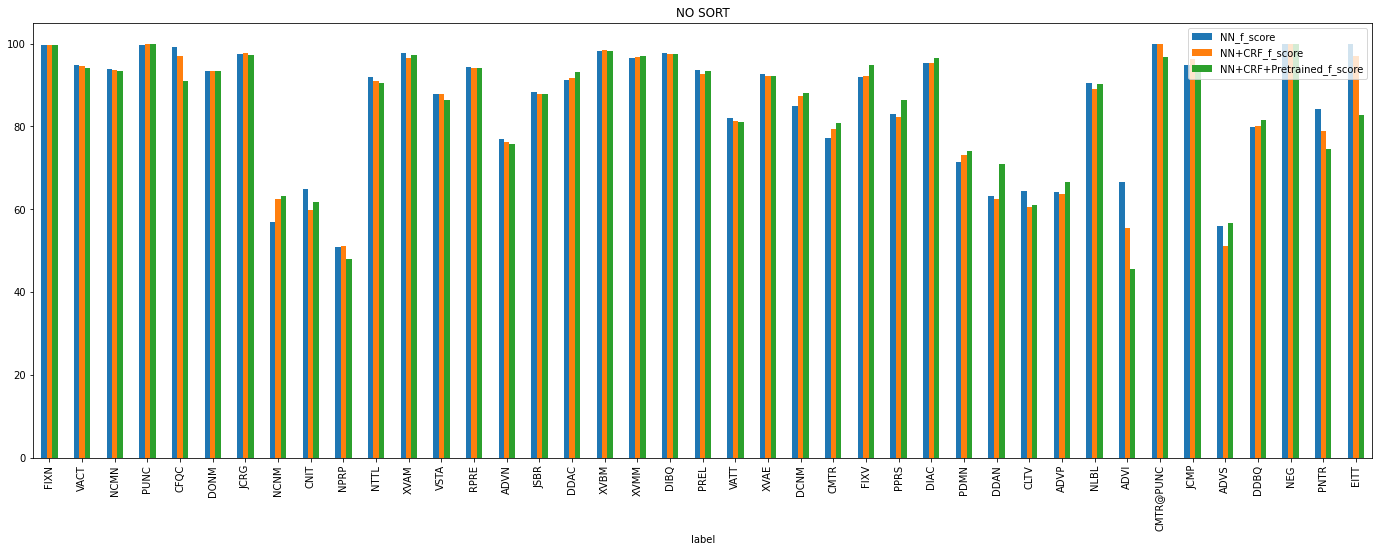

In [241]:
merged2.plot.bar(x='label', figsize=(24, 8), title='NO SORT')

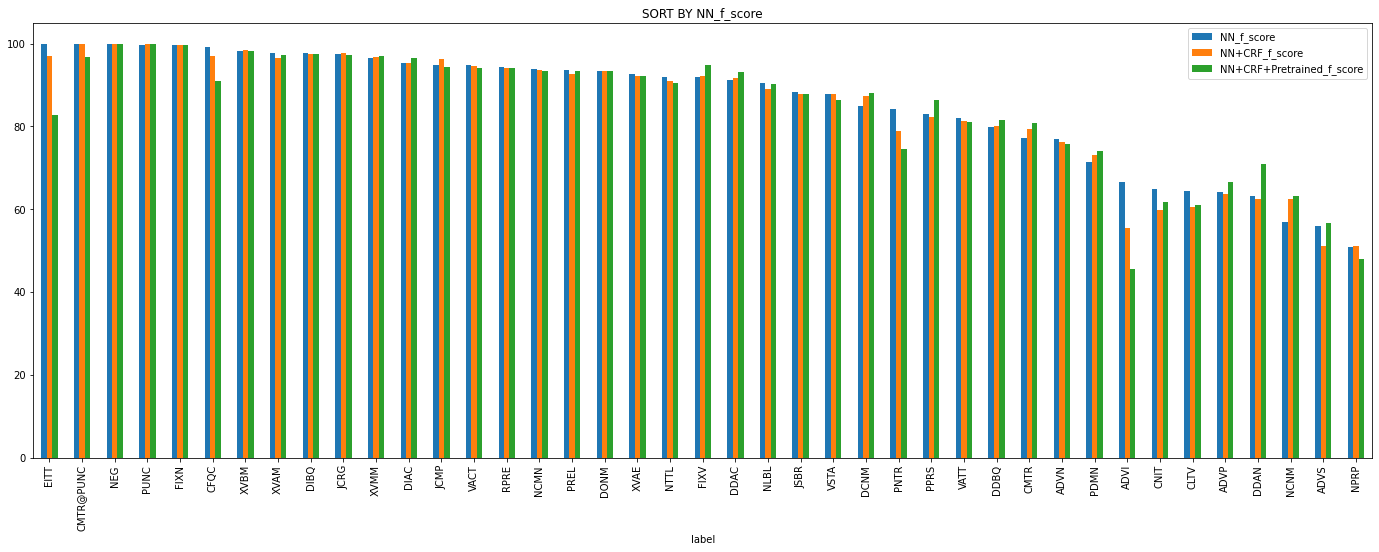

In [244]:
merged2.sort_values(by=['NN_f_score'], ascending=False).plot.bar(x='label', figsize=(24, 8), title='SORT BY NN_f_score')

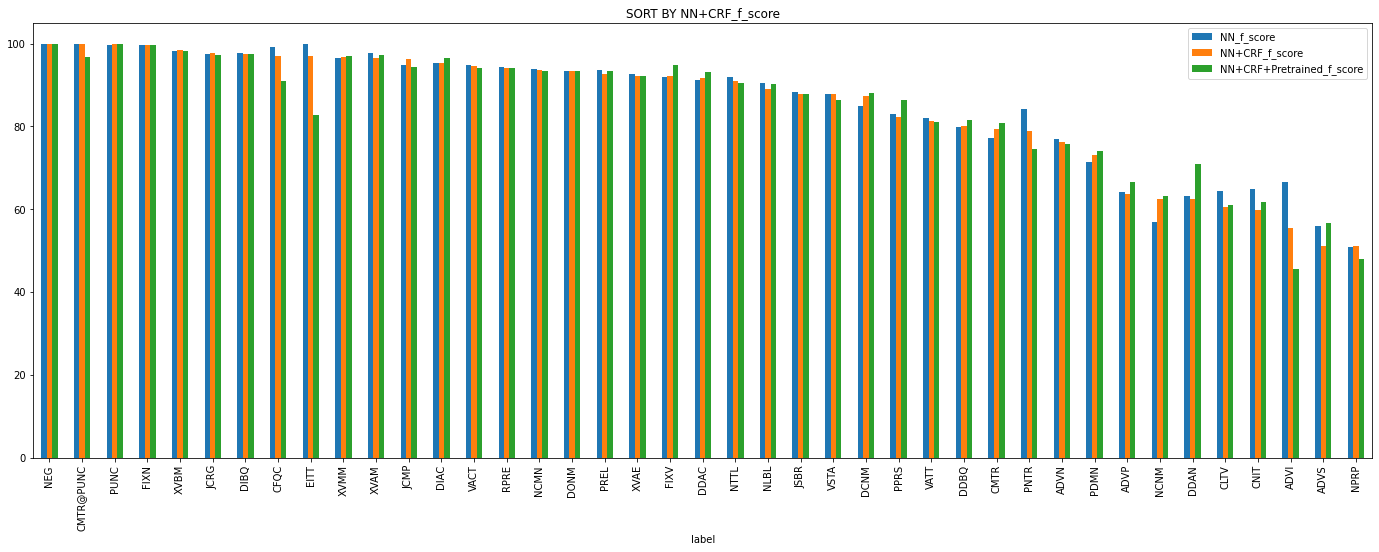

In [245]:
merged2.sort_values(by=['NN+CRF_f_score'], ascending=False).plot.bar(x='label', figsize=(24, 8), title='SORT BY NN+CRF_f_score')

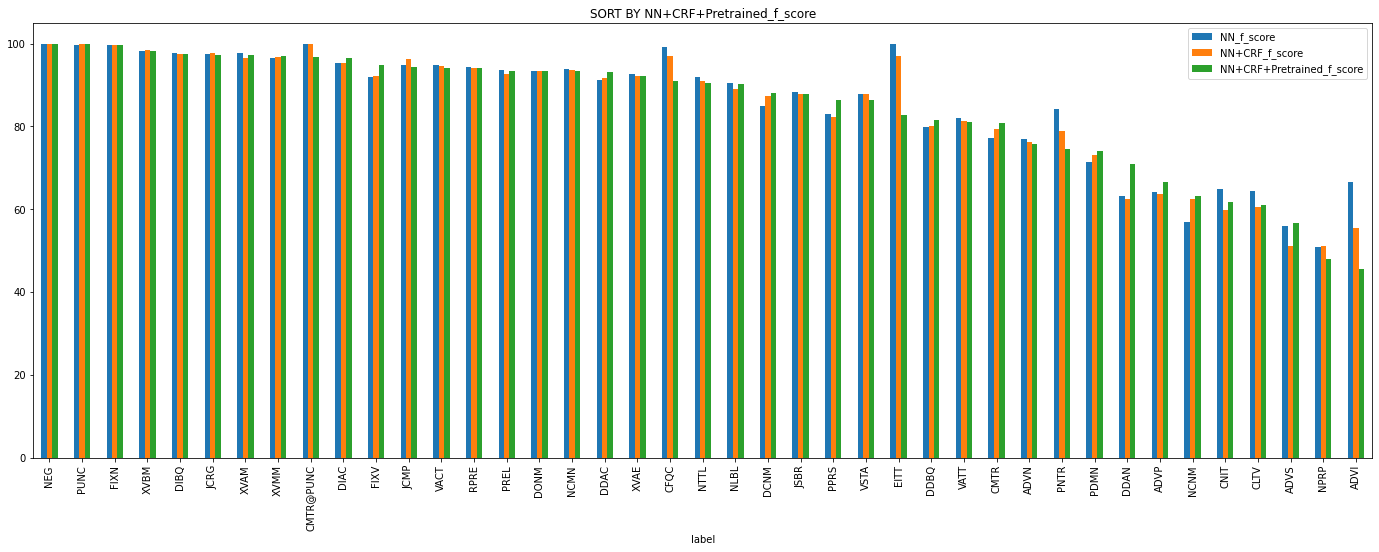

In [246]:
merged2.sort_values(by=['NN+CRF+Pretrained_f_score'], ascending=False).plot.bar(x='label', figsize=(24, 8), title='SORT BY NN+CRF+Pretrained_f_score')

### #TODO 4

Upon inference, the model also returns its transition matrix, which is learned during training. Your task is to observe and report whether the returned matrix is sensible. You can provide some examples to support your argument.

#### Hint : The transition matrix must have the shape  of (num_class, num_class).

<b>Write your answer here :</b>

```
TOPICS: 
  HIGH FREQUENCY:
    - FIXV -> VATT
    - DIBQ -> CNIT
    - DCNM -> CMTR

  LOW FREQUENCY:
    - FIXV -> ADVN
    - FIXV -> PUNC
    - NLBL -> NLBL
```

```
FIXV Samples: ['โดย', 'อย่าง', 'เป็น', 'ความ']
```

```
VATT Samples: ['สูง', 'สำคัญ', 'ตรง', 'ยิ่ง', 'ใกล้ชิด']
```

```
DIBQ Samples: ['หลาย', 'แทบ', 'ทุก', 'บรรดา', 'นานา']
```

```
CNIT Samples: ['เล่ม', 'ชั้น', 'ประการ', 'สาขา', 'ฉบับ']
```

```
DCNM Samples: ['1', 'หนึ่ง', '10', '55', 'เดียว']
```

```
CMTR Samples: ['ปี', 'บิท', 'แรงม้า', 'ไบท์', 'Kbyte']
```

```
ADVN Samples: ['มาก', 'ยิ่งขึ้น', 'มหาศาล', 'ด้วย', 'สืบไป']
```

```
PUNC Samples: ['<space>',
 '<minus>',
 '<left_parenthesis>',
 '<right_parenthesis>',
 '<asterisk>']
```

```
NLBL Samples: ['1', '2', '3', '3.1', '4']
```

<hr>

## High frequency transitions

These examples are all self-explanatory, so I will not write any further explanation in each pair of transition.

<hr>

### FIXV (Adverbial prefix) -> VATT (Attributive verb)

```
- อย่าง สูง
- ความ ใกล้ชิด
- โดย ตรง
```

<hr>

### DIBQ (Indefinite determiner, between noun
and classifier or preceding quantitative
expression) -> CNIT (Unit classifier)

```
- หลาย ชั้น
- นานา ฉบับ
- ทุก ประการ
```

<hr>

### DCNM (Determiner, cardinal number
expression) -> CMTR (Measurement classifier)

```
- หนึ่ง ปี
- 10 แรงม้า
- 55 Kbyte
```

<hr>

## Low frequency transitions

<hr>

### FIXV (Adverbial prefix) -> ADVN (Adverb with normal form)

Take a look at:

```
- อย่าง มหาศาล
- เป็น สืบไป
- โดย ยิ่งขึ้น
```

These sound very common and should be titled as high freq, but according to the paper, FIXV -> ADVN word are combined and resulting in ADVP (Adverb with prefixed form) instead. So this transition in theory, should never happen.

<hr>

### FIXV (Adverbial prefix) -> PUNC (Punctuation)

Usually, we do not cut or end sentences with PUNC after FIXV, some examples might help understand this a bit better:

```
- อย่าง -
- เป็น *
- โดย )

(These never really happens in usual sentences)
```

<hr>

### NLBL (Label noun) -> NLBL (Label noun)

Label nouns are nouns labeled in front of lists, for example: `1).`, `ก).`, or `2.3.4).`. They never are written back to back to each other

<hr>



In [ ]:
def find_samples(tag_in, n):
  res = []
  for sentence in train_data:
    for word, tag in sentence:
      if tag_in == tag and word not in res:
        res.append(word)
      if len(res) >= n: 
        return res
  return res
find_samples('DCNM', 5)

['1', 'หนึ่ง', '10', '55', 'เดียว']

In [ ]:
find_samples('CMTR', 5)

['ปี', 'บิท', 'แรงม้า', 'ไบท์', 'Kbyte']

In [ ]:
transition_matrix = crf.transitions.numpy()

In [ ]:
transition_matrix.shape

(48, 48)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tag_list = ['ZERO']
for key, value in label_to_idx.items():
  # print(f"{key}, {value}")
  tag_list.append(key)

tag_list

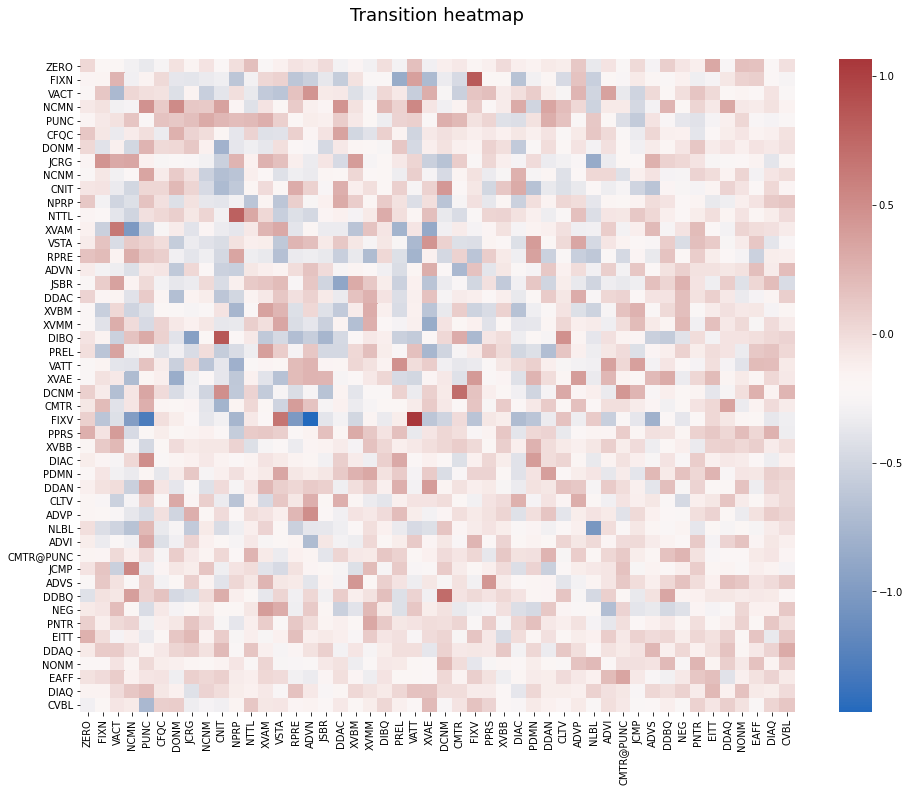

In [249]:
fig, ax = plt.subplots(figsize=(16,12))
plt.title("Transition heatmap", fontsize=18)

ttl = ax.title
ttl.set_position([0.5, 1.05])

ax = sns.heatmap(transition_matrix, cmap='vlag', xticklabels=tag_list, yticklabels=tag_list)
plt.show()